In [1]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets 
from torch.utils.data import DataLoader
# from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os 

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:1


In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

class CustomImageListDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, class_to_idx, transform=None):
        with open(file_list, "r") as f:
            self.samples = [line.strip() for line in f]
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        class_folder = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx.get(class_folder, -1)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# ---------------- Create a combined class mapping ----------------
root_dir = "dataset/imagenet_tests"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Collect class mappings from all 10 partitions
combined_class_to_idx = {}
for i in range(1, 11):
    test_dir = os.path.join(root_dir, f"test{i}")
    dataset = datasets.ImageFolder(test_dir, transform=transform)
    combined_class_to_idx.update(dataset.class_to_idx)

print(f"✅ Combined class mapping built: {len(combined_class_to_idx)} total classes")

# ---------------- Load your 1000-image subset ----------------
subset_file = "results/hard_cases_missed_by_mobilenet.txt"
hard_dataset = CustomImageListDataset(subset_file, class_to_idx=combined_class_to_idx, transform=transform)
hard_loader = DataLoader(hard_dataset, batch_size=1, shuffle=False)

print(f"✅ Loaded {len(hard_dataset)} hard samples")

✅ Combined class mapping built: 1000 total classes
✅ Loaded 1000 hard samples


In [4]:
def get_models(dataset, model_name, key): 
    if dataset == 'imagenet':
        # save_root_path = r"checkpoint/tinyimagenet"
        model = timm.create_model(model_name, pretrained=True, num_classes=1000).to(device)
        model.eval()
        if 'inc' in key or 'vit' in key or 'bit' in key:
            return torch.nn.Sequential(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), model)
        else:
            return torch.nn.Sequential(transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), model)

In [5]:
timm.list_models('*dyn*')

[]

### Attack 

In [6]:
class NormalizedModel(nn.Module):
    def __init__(self, model, mean, std):
        super().__init__()
        self.model = model
        self.register_buffer('mean', torch.tensor(mean).view(1,3,1,1))
        self.register_buffer('std', torch.tensor(std).view(1,3,1,1))

    def forward(self, x):
        x = (x - self.mean) / self.std
        return self.model(x)

def get_last_linear_layer(model):
    """
    Find the last Linear layer in timm models or wrapped models (NormalizedModel).
    """
    # unwrap NormalizedModel if needed
    if isinstance(model, NormalizedModel):
        model = model.model

    # Common attribute names for classifier heads
    candidate_attrs = ['head', 'heads', 'fc', 'classifier', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If it's a Sequential or Module, search inside
            if isinstance(layer, nn.Module):
                last_linear = None
                for m in reversed(list(layer.modules())):
                    if isinstance(m, nn.Linear):
                        last_linear = m
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError(f"No Linear layer found in model {model.__class__.__name__}")



def get_features_before_last_linear(model, x):
    """
    Extract features before the final classifier, works for CNNs and ViTs.
    """
    # unwrap NormalizedModel if present
    if isinstance(model, NormalizedModel):
        model = model.model

    # Common classifier attributes
    candidate_attrs = ['head', 'heads', 'fc', 'classifier', 'mlp_head']
    classifier = None
    for attr in candidate_attrs:
        if hasattr(model, attr):
            classifier = getattr(model, attr)
            break

    features = {}

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    if classifier is not None:
        handle = classifier.register_forward_hook(hook)
    else:
        # fallback: attach hook to last module
        last_module = list(model.modules())[-1]
        handle = last_module.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)
    handle.remove()

    if 'feat' not in features:
        raise RuntimeError(f"Failed to capture features from model {model.__class__.__name__}")

    return features['feat']

In [176]:
import torch
import torch.nn.functional as F
from torch import nn

def get_gaussian_kernel(kernel_size: int = 15, sigma: float = 3.0, channels: int = 3, device='cpu'):
    ax = torch.arange(-(kernel_size // 2), kernel_size // 2 + 1, device=device, dtype=torch.float32)
    xx, yy = torch.meshgrid(ax, ax, indexing='xy')
    kernel = torch.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / kernel.sum()
    kernel = kernel.view(1, 1, kernel_size, kernel_size)
    kernel = kernel.repeat(channels, 1, 1, 1)  # groups conv
    return kernel

def diverse_input(x: torch.Tensor, prob: float = 0.7, resize_min: int = 290, resize_max: int = 330):
    """
    DIM: random resize + padding with probability `prob`.
    Works on batch x of shape (B,C,H,W). If prob check fails, returns x unchanged.
    """
    if prob <= 0 or torch.rand(1).item() > prob:
        return x
    B, C, H, W = x.shape
    # choose a random size (square)
    size = int(torch.randint(resize_min, resize_max + 1, (1,)).item())
    x_resized = F.interpolate(x, size=(size, size), mode='bilinear', align_corners=False)
    pad_h = max(0, H - size)
    pad_w = max(0, W - size)
    pad_top = int(torch.randint(0, pad_h + 1, (1,)).item()) if pad_h > 0 else 0
    pad_left = int(torch.randint(0, pad_w + 1, (1,)).item()) if pad_w > 0 else 0
    pad_bottom = pad_h - pad_top
    pad_right = pad_w - pad_left
    x_padded = F.pad(x_resized, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0.0)
    # if resized is bigger than original, center crop
    if size > H:
        start_h = (size - H) // 2
        start_w = (size - W) // 2
        x_padded = x_padded[:, :, start_h:start_h+H, start_w:start_w+W]
    return x_padded

def ti_dim_mi_fgsm(models,
                   images: torch.Tensor,
                   labels: torch.Tensor,
                   epsilon: float = 8/255,
                   steps: int = 10,
                   alpha: float = None,
                   prob: float = 0.7,
                   mu: float = 1.0,
                   kernel_size: int = 15,
                   sigma: float = 3.0,
                   targeted: bool = False,
                   clip_min: float = 0.0,
                   clip_max: float = 1.0,
                   device: str = 'cuda',
                   normalize: bool = False,
                   mean: torch.Tensor = None,
                   std: torch.Tensor = None,
                   ensemble_grad_mode: str = 'avg'  # 'avg' or 'sum'
                   ):
    """
    TI-DIM-MI-FGSM attack.
    - models: nn.Module or list of nn.Module
    - images: float tensor in [0,1], shape (B,C,H,W)
    - labels: long tensor (B,)
    - ensemble_grad_mode: 'avg' => average gradients across models; 'sum' => sum gradients (equivalent to sum-of-losses)
    Returns adversarial images tensor (B,C,H,W)
    """
    if isinstance(models, nn.Module):
        models = [models]
    for m in models:
        m.eval()

    images = images.to(device).clone().detach()
    orig = images.clone().detach()
    labels = labels.to(device)
    B, C, H, W = images.shape

    if alpha is None:
        alpha = epsilon / float(steps)

    kernel = get_gaussian_kernel(kernel_size, sigma, channels=C, device=device)
    grad_m = torch.zeros_like(images).to(device)

    if normalize:
        assert mean is not None and std is not None
        mean = mean.to(device).view(1, C, 1, 1)
        std = std.to(device).view(1, C, 1, 1)
        def norm_fn(x): return (x - mean) / std
    else:
        norm_fn = lambda x: x

    x_adv = images.clone().detach()

    for t in range(steps):
        x_adv.requires_grad_(True)
        # DIM transform (stochastic)
        x_in = diverse_input(x_adv, prob=prob)
        x_in_norm = norm_fn(x_in)

        # compute per-model loss and/or logits
        losses = []
        grads_per_model = []
        # We'll compute per-model loss and gradient wrt x_adv via autograd.grad separately to support ensemble_grad_mode
        for m in models:
            logits = m(x_in_norm)
            loss = F.cross_entropy(logits, labels, reduction='mean')
            if targeted:
                loss = -loss
            losses.append(loss)

        if ensemble_grad_mode == 'sum':
            total_loss = sum(losses)
            # gradient wrt x_adv
            grad = torch.autograd.grad(total_loss, x_adv, retain_graph=False, create_graph=False)[0]
        else:  # 'avg' or default
            grads = []
            for loss in losses:
                g = torch.autograd.grad(loss, x_adv, retain_graph=True, create_graph=False)[0]
                grads.append(g)
            # average gradients
            grad = sum(grads) / float(len(grads))

        # TI: smooth gradient with gaussian kernel (grouped conv)
        grad_conv = F.conv2d(grad, weight=kernel, bias=None, stride=1, padding=kernel_size//2, groups=C)

        # normalize gradient by mean absolute value per-sample to stabilize momentum
        denom = torch.mean(torch.abs(grad_conv), dim=(1,2,3), keepdim=True) + 1e-12
        grad_norm = grad_conv / denom

        # update momentum
        grad_m = mu * grad_m + grad_norm

        # update adversarial image (MI-FGSM sign update)
        if targeted:
            x_adv = x_adv.detach() - alpha * torch.sign(grad_m)
        else:
            x_adv = x_adv.detach() + alpha * torch.sign(grad_m)

        # clip to epsilon ball and [clip_min,clip_max]
        x_adv = torch.max(torch.min(x_adv, orig + epsilon), orig - epsilon)
        x_adv = torch.clamp(x_adv, clip_min, clip_max).detach()

        # zero gradients in models (if any)
        for m in models:
            m.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.detach_()
            x_adv.grad.zero_()

    return x_adv

In [240]:
ens_models = [
    # get_models("imagenet", "resnet18", "resnet18"), 
    # get_models("imagenet", "inception_v3", "inc_v3"), 
    # get_models("imagenet", "deit_tiny_patch16_224", "deit_t"),
    # get_models("imagenet", "vit_tiny_patch16_224", "vit_t"), 
    # get_models("imagenet", "efficientnet_b0", "efficientnet_b0"), 
    get_models("imagenet", "xcit_tiny_12_p8_224", "swin_t"), 
] 

target_models = [
    # get_models("imagenet", "resnet152", "resnet152"),
    # get_models("imagenet", "wide_resnet101_2", "wrn101_2"),     
    # get_models("imagenet", "regnety_320", "regnety_320"),
    # get_models("imagenet", "vgg19", "vgg19"),
    # get_models("imagenet", "vit_base_patch16_224", "vit_b"),
    # get_models("imagenet", "deit_base_patch16_224", "deit_b"),
    # get_models("imagenet", "swin_base_patch4_window7_224", "swin_b"), 
    # get_models("imagenet", "mixer_b16_224", "vit_t"), 
    # get_models("imagenet", "convmixer_768_32", "vit_t")
] 

In [241]:
import torchattacks

model = ens_models[0]
model.to(device)
model.eval() 

print("Loaded")

Loaded


In [242]:
from torchmetrics.functional.image import structural_similarity_index_measure as ssim
import torch

# --- before loop (clear previous lists) ---
adv_list = []
orig_list = []
labels_list = []
orig_preds = []
adv_preds = []
noise_rates = []
pixel_diffs = []

def ensure_batch(x):
    return x if x.dim() == 4 else x.unsqueeze(0)

def to_unit_range(x):
    """
    Ensure x is in [0,1]. If tensor values appear to be in [0,255] (max>1.5),
    convert by dividing by 255. Returns a float tensor on same device.
    """
    x = ensure_batch(x).float()
    if x.max().item() > 1.5:
        x = x / 255.0
    return torch.clamp(x, 0.0, 1.0)

# --- attack loop (same as yours, but using the simplified functions) ---
for img, label in tqdm(hard_loader, desc="Generating MI-FGSM adversarials (GPU)"):
    img, label = img.to(device), label.to(device)

    with torch.enable_grad():
        # attacker = torchattacks.MIFGSM(model, eps=16/255, alpha=2/255, steps=10)
        # attacker = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=10)
        # attacker = torchattacks.CW(model, c=1, kappa=0, steps=50, lr=0.01) 
        adv_img = ti_dim_mi_fgsm(model, img, label, epsilon=16/255, steps=10, prob=0.7, mu=1.0,
                        kernel_size=15, sigma=3.0, device=device, ensemble_grad_mode='avg')
        # adv_img = attacker(img, label)
        # attacker = StAdv(model, device=device) 
        # adv = attacker.perturb(imgs, labels, steps=200, lr=1e-2, max_flow_pixels=5, flow_reg=0.01, tv_reg=0.2, verbose=False)

        # adv_img = advedge_with_feature_guidance(model, img,label, 
        #                               eps=8/255, steps=10, alpha=2/255, feature_guided=True, feature_weight = 1, 
        #                               edge_clamp=(0.2, 0.8), device=device)

    with torch.no_grad():
        orig_pred = model(img).argmax(dim=1)
        adv_pred = model(adv_img).argmax(dim=1)

    # store for later (move to CPU)
    adv_list.append(adv_img.squeeze(0).cpu())
    orig_list.append(img.squeeze(0).cpu())
    labels_list.append(label.squeeze(0).cpu())
    orig_preds.append(orig_pred.squeeze(0).cpu())
    adv_preds.append(adv_pred.squeeze(0).cpu())

    # compute SSIM and pixel diffs on [0,1] images
    img_for_ssim = to_unit_range(img)       # (1,C,H,W) in [0,1]
    adv_for_ssim = to_unit_range(adv_img)   # (1,C,H,W) in [0,1]

    ssim_val = ssim(adv_for_ssim, img_for_ssim)  # scalar tensor
    noise_rates.append((1.0 - float(ssim_val)))
    pixel_diffs.append((adv_for_ssim - img_for_ssim).abs().mean().item())

# --- stack everything on CPU ---
adv_all = torch.stack(adv_list).cpu()
orig_all = torch.stack(orig_list).cpu()
labels_all = torch.stack(labels_list).cpu()
orig_preds_all = torch.stack(orig_preds).cpu()
adv_preds_all = torch.stack(adv_preds).cpu()

noise_rates = torch.tensor(noise_rates)
pixel_diffs = torch.tensor(pixel_diffs)

print(f"✅ Generated {adv_all.size(0)} adversarial images. Shape: {adv_all.shape}")
print(f"Original preds match labels: {(orig_preds_all == labels_all).sum().item()}/{len(labels_all)}")
print(f"Adversarial preds differ: {(orig_preds_all != adv_preds_all).sum().item()}/{len(labels_all)}")
print(f"Noise (1 - SSIM): mean={noise_rates.mean():.6f}, std={noise_rates.std():.6f}, min={noise_rates.min():.6f}, max={noise_rates.max():.6f}")
print(f"Mean absolute pixel diff (after clamp to [0,1]): mean={pixel_diffs.mean():.6f}, std={pixel_diffs.std():.6f}")


Generating MI-FGSM adversarials (GPU): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:56<00:00,  1.12it/s]


✅ Generated 1000 adversarial images. Shape: torch.Size([1000, 3, 224, 224])
Original preds match labels: 963/1000
Adversarial preds differ: 938/1000
Noise (1 - SSIM): mean=0.187598, std=0.078721, min=0.023035, max=0.567631
Mean absolute pixel diff (after clamp to [0,1]): mean=0.039039, std=0.004200


In [243]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

batch_size = 32  # tune this for your GPU
dataset = TensorDataset(adv_all, labels_all)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                    num_workers=4, pin_memory=True)

In [248]:
target_models = [
    # get_models("imagenet", "resnet152", "resnet152"),
    # get_models("imagenet", "wide_resnet101_2", "wrn101_2"),     
    # get_models("imagenet", "regnety_320", "regnety_320"),
    # get_models("imagenet", "vgg19", "vgg19"),
    # get_models("imagenet", "vit_base_patch16_224", "vit_b"),
    # get_models("imagenet", "deit_base_patch16_224", "deit_b"),
    get_models("imagenet", "swin_base_patch4_window7_224", "swin_b"), 
    get_models("imagenet", "mixer_b16_224", "vit_t"), 
    get_models("imagenet", "convmixer_768_32", "vit_t")
] 

# target_models = [
#     # get_models("imagenet", "mobilenetv1_100", "mobilenetv1_100"),  
#     get_models("imagenet", "resnet18", "resnet18"), 
#     get_models("imagenet", "inception_v3", "inc_v3"), 
#     get_models("imagenet", "deit_tiny_patch16_224", "deit_t"),
#     get_models("imagenet", "vit_tiny_patch16_224", "vit_t"), 
#     get_models("imagenet", "efficientnet_b0", "efficientnet_b0"), 
#     get_models("imagenet", "xcit_tiny_12_p8_224", "swin_t"), 
# ] 

In [249]:
with torch.no_grad():
    for t_model in target_models:
        name = getattr(t_model, "name", t_model.__class__.__name__)
        t_model.eval()
        t_model.to(device)

        fooled = 0
        total = 0

        for imgs_cpu, labels_cpu in tqdm(loader, desc=f"ASR {name}"):
            # Move to device here
            imgs = imgs_cpu.to(device, non_blocking=True)
            labels = labels_cpu.to(device, non_blocking=True)

            outputs = t_model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = outputs.argmax(dim=1)

            fooled += (preds != labels).sum().item()
            total += labels.size(0)

            # free cache per batch (helps on tight GPUs)
            if device.type == "cuda":
                torch.cuda.empty_cache()

        asr = 100.0 * fooled / total if total > 0 else 0.0
        print(f"{name}: ASR = {asr:.2f}%  ({fooled}/{total} fooled)")

ASR Sequential: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.54it/s]


Sequential: ASR = 28.00%  (280/1000 fooled)


ASR Sequential: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.05it/s]


Sequential: ASR = 47.10%  (471/1000 fooled)


ASR Sequential: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.50it/s]

Sequential: ASR = 50.10%  (501/1000 fooled)


In [132]:
import torch
from torchmetrics.functional.image import structural_similarity_index_measure as ssim

# assume adv_all and orig_all are both (N, C, H, W) and values are in [0, 1]
ssim_scores = []
for orig, adv in zip(orig_all, adv_all):
    score = ssim(adv.unsqueeze(0), orig.unsqueeze(0))  # compute SSIM per image
    ssim_scores.append(score.item())

ssim_scores = torch.tensor(ssim_scores)
noise_rates = 1 - ssim_scores  # 1 - SSIM

print(f"Average noise rate: {noise_rates.mean():.4f}")

Average noise rate: 0.3757


In [56]:
orig_all.shape

torch.Size([1000, 3, 224, 224])

In [57]:
adv_all.shape

torch.Size([1000, 3, 224, 224])

### GradCAM 

In [37]:
class NormalizedModel(nn.Module):
    def __init__(self, model, mean, std):
        super().__init__()
        self.model = model
        self.register_buffer('mean', torch.tensor(mean).view(1,3,1,1))
        self.register_buffer('std', torch.tensor(std).view(1,3,1,1))

    def forward(self, x):
        x = (x - self.mean) / self.std
        return self.model(x)

def get_last_linear_layer(model):
    """
    Find the last Linear layer in timm models or wrapped models (NormalizedModel).
    """
    # unwrap NormalizedModel if needed
    if isinstance(model, NormalizedModel):
        model = model.model

    # Common attribute names for classifier heads
    candidate_attrs = ['head', 'heads', 'fc', 'classifier', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If it's a Sequential or Module, search inside
            if isinstance(layer, nn.Module):
                last_linear = None
                for m in reversed(list(layer.modules())):
                    if isinstance(m, nn.Linear):
                        last_linear = m
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError(f"No Linear layer found in model {model.__class__.__name__}")



def get_features_before_last_linear(model, x):
    """
    Extract features before the final classifier, works for CNNs and ViTs.
    """
    # unwrap NormalizedModel if present
    if isinstance(model, NormalizedModel):
        model = model.model

    # Common classifier attributes
    candidate_attrs = ['head', 'heads', 'fc', 'classifier', 'mlp_head']
    classifier = None
    for attr in candidate_attrs:
        if hasattr(model, attr):
            classifier = getattr(model, attr)
            break

    features = {}

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    if classifier is not None:
        handle = classifier.register_forward_hook(hook)
    else:
        # fallback: attach hook to last module
        last_module = list(model.modules())[-1]
        handle = last_module.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)
    handle.remove()

    if 'feat' not in features:
        raise RuntimeError(f"Failed to capture features from model {model.__class__.__name__}")

    return features['feat']

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Grad-CAM
# -------------------------
def grad_cam(model: nn.Module, image: torch.Tensor, target_class: int = None, last_conv: nn.Module = None):
    """
    Compute Grad-CAM for a single image.
    
    Args:
        model: nn.Module
        image: Tensor [1,C,H,W]
        target_class: int (if None, uses model prediction)
        last_conv: nn.Module, optional last convolution layer (auto-find if None)
        
    Returns:
        cam: Tensor [H,W], normalized to [0,1]
        target_class: int
    """
    model.eval()
    image = image.to(next(model.parameters()).device).requires_grad_(True)

    # Auto-detect last conv layer if not provided
    if last_conv is None:
        last_conv = None
        for module in reversed(list(model.modules())):
            if isinstance(module, nn.Conv2d):
                last_conv = module
                break
        if last_conv is None:
            raise RuntimeError("No Conv2d layer found in model.")

    # Store activations and gradients
    activations = []
    gradients = []

    def forward_hook(module, inp, out):
        activations.append(out)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    handle_f = last_conv.register_forward_hook(forward_hook)
    handle_b = last_conv.register_backward_hook(backward_hook)

    # Forward
    output = model(image)
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    loss = output[0, target_class]

    model.zero_grad()
    loss.backward()

    # Compute CAM
    grad = gradients[0]            # (1,C,H,W)
    act = activations[0]           # (1,C,H,W)
    weights = grad.mean(dim=(2,3), keepdim=True)  # channel importance
    cam = (weights * act).sum(dim=1, keepdim=True)  # (1,1,H,W)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=image.shape[2:], mode='bilinear', align_corners=False)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    handle_f.remove()
    handle_b.remove()

    return cam.detach().squeeze().cpu(), target_class


# -------------------------
# Visualization
# -------------------------
def show_cam_comparison(model, orig: torch.Tensor, adv: torch.Tensor, true_label: int,
                        last_conv: nn.Module = None):
    model.eval()
    device = next(model.parameters()).device

    orig = orig.unsqueeze(0).float().to(device)
    adv = adv.unsqueeze(0).float().to(device)

    cam_orig, pred_orig = grad_cam(model, orig, target_class=true_label, last_conv=last_conv)
    adv_label = model(adv).argmax(dim=1).item()
    cam_adv, pred_adv = grad_cam(model, adv, target_class=adv_label, last_conv=last_conv)

    # detach before converting to numpy
    orig_img = orig.squeeze().permute(1,2,0).detach().cpu().numpy()
    adv_img = adv.squeeze().permute(1,2,0).detach().cpu().numpy()
    cam_orig = cam_orig.squeeze().numpy()
    cam_adv = cam_adv.squeeze().numpy()

    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    axes[0,0].imshow(orig_img)
    axes[0,0].set_title(f"Original (Label {true_label})")
    axes[0,1].imshow(cam_orig, cmap='jet')
    axes[0,1].set_title(f"Grad-CAM (Pred {pred_orig})")
    axes[0,2].imshow(orig_img)
    axes[0,2].imshow(cam_orig, cmap='jet', alpha=0.5)
    axes[0,2].set_title("Overlay")

    axes[1,0].imshow(adv_img)
    axes[1,0].set_title(f"Adversarial (Pred {adv_label})")
    axes[1,1].imshow(cam_adv, cmap='jet')
    axes[1,1].set_title(f"Grad-CAM (Pred {pred_adv})")
    axes[1,2].imshow(adv_img)
    axes[1,2].imshow(cam_adv, cmap='jet', alpha=0.5)
    axes[1,2].set_title("Overlay")

    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

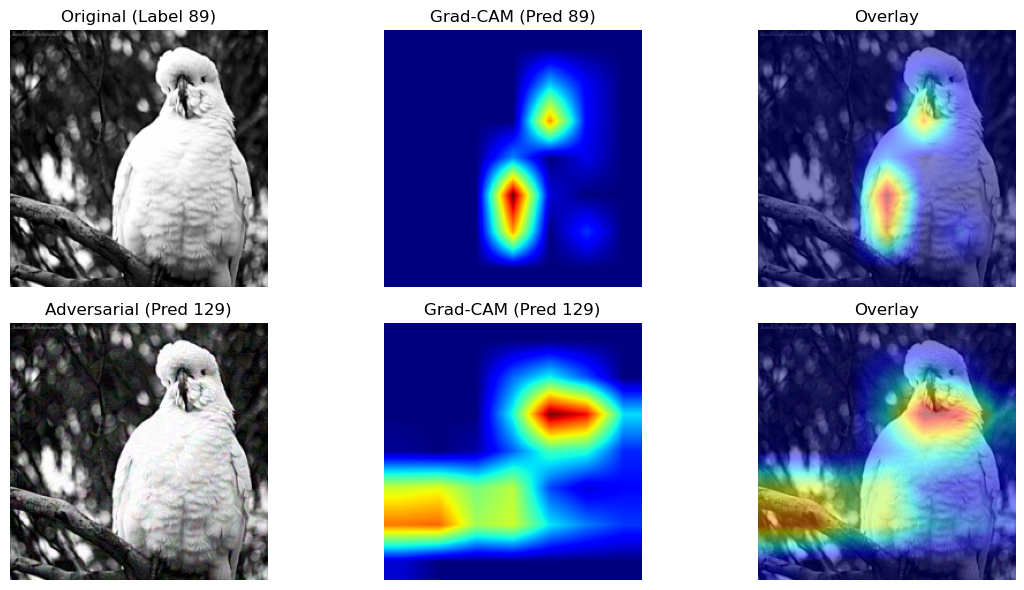

In [60]:
i = 14 # index of sample to visualize
show_cam_comparison(
    model,
    orig_all[i],
    adv_all[i],
    true_label=int(labels_all[i]),
)

In [ ]:
target_models = [
    # get_models("imagenet", "resnet152", "resnet152"),
    # get_models("imagenet", "wide_resnet101_2", "wrn101_2"),     
    # get_models("imagenet", "regnety_320", "regnety_320"),
    # get_models("imagenet", "vgg19", "vgg19"),
    # get_models("imagenet", "vit_base_patch16_224", "vit_b"),
    # get_models("imagenet", "deit_base_patch16_224", "deit_b"),
    # get_models("imagenet", "swin_base_patch4_window7_224", "swin_b"), 
    # get_models("imagenet", "mixer_b16_224", "vit_t"), 
    # get_models("imagenet", "convmixer_768_32", "vit_t")
] 

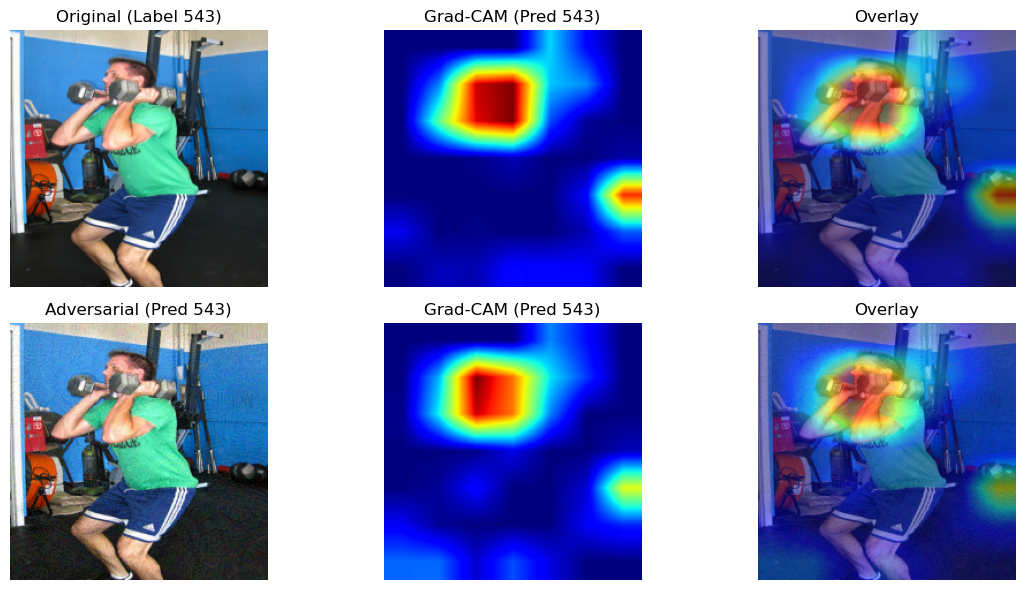

In [72]:
i = 58 # index of sample to visualize
show_cam_comparison(
    get_models("imagenet", "regnety_320", "regnety_320"),
    orig_all[i],
    adv_all[i],
    true_label=int(labels_all[i]),
)

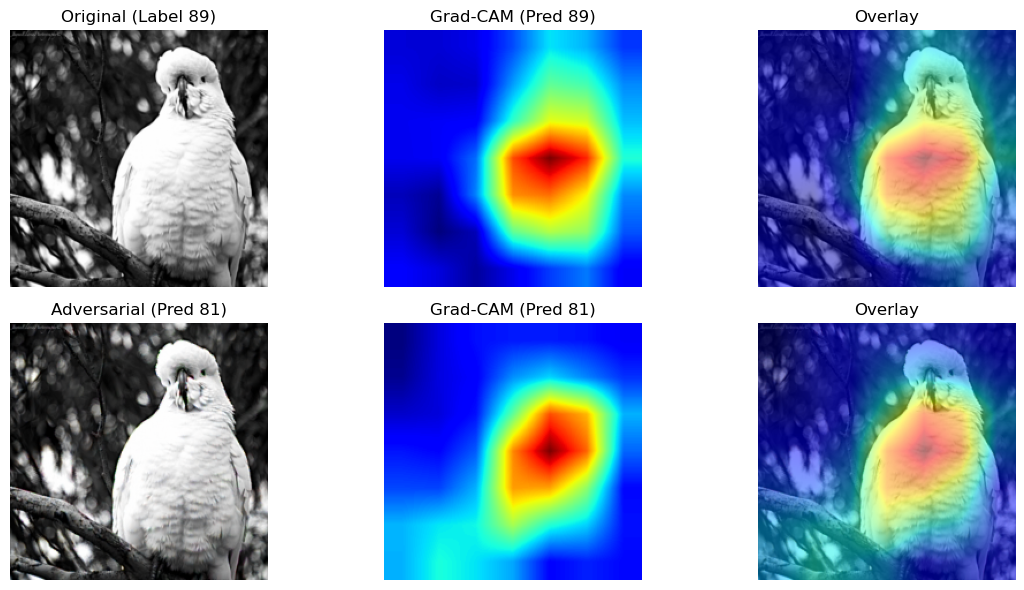

In [102]:
# select one image from your dataset
i = 14
orig = orig_all[i]
adv = advedge_for_gradcam(get_models("imagenet", "efficientnet_b0", "efficientnet_b0"), 
                          orig.unsqueeze(0), labels_all[i].unsqueeze(0), device)[0]

show_cam_comparison(get_models("imagenet", "efficientnet_b0", "efficientnet_b0"),
                    orig, adv, true_label=int(labels_all[i]))